# **East Africa drought study - analysis of model data**

_Model fitting is less stable when using lognormal - carry out transformation separately_

In [89]:
source("../wwa_nonstationary_fitting.r")

# list return periods to use in later analysis
return_periods <- list("mam" = 10, "ond" = 5, "24" = 20, "pet" = 3, "spei" = 10)

---
## **Prep & testing**

In [12]:
# load data, fix values for factual & counterfactual climate

df <- merge(merge(load_ts("ts/EA-drought_gmst-smoothed.dat", col.names = c("year", "gmst")),
                  load_ts("ts/EA-drought_detrended-nino-ond.dat", col.names = c("year", "nino_ond"))),
            load_ts("ts/EA-drought_pr-ond_cpc.dat", c("year", "pr_ond")))
df["log10pr"] <- log10(df$pr_ond)

gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- df[df$year == 2022, "nino_ond"]
ondnino_cf <- ondnino_2022

In [11]:
# wrapper function to get bootstrapped confidence intervals for spreadsheet
bootstrap_obs_results <- function(mdl, cov1, cov2, cov1_cf = NA, cov2_cf = NA, seed = 101, nsamp = 1000, dp = 5, convert_logs = T) {

    # create internal function to give required results
    get_mdl_values <- function(mdl, ev, cov1, cov2, cov1_cf = NA, cov2_cf = NA) {
        
        pars <- mdl$par
        
        rp <- 1/map_to_u(mdl, x = event_value, cov1 = cov1, cov2 = cov2)
        rp_cf <- 1/map_to_u(mdl, x = event_value, cov1 = cov1_cf, cov2 = cov2_cf)
        rl_cf <- map_from_u(1/rp, mdl, cov1 = cov1_cf, cov2 = cov2_cf)
        
        # if using log values, convert back to natural units
        if(convert_logs) {
            if(substr(mdl$varnm,1,5) == "log10") {
                ev <- 10^ev
                rl_cf <- 10^rl_cf
            } else if(substr(mdl$varnm,1,3) == "log") {
                ev <- exp(ev)
                rl_cf <- exp(rl_cf)
            }
        }
        c(pars, 
          "dispersion" = unname(pars["sigma0"] / pars["mu0"]),
          "event_magnitude" = ev,
          "return_period" = rp,
          "probability_ratio" = rp_cf/rp,
          "abs_change_in_intensity" = (ev - rl_cf),
          "rel_change_in_intensity" = ((ev - rl_cf) / rl_cf) * 100
         )   
    }
    
    # get best estimate from the observed data
    event_value <- mdl$x[mdl$ev_idx]
    mdl_res <- get_mdl_values(mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    mdl_df <- setNames(data.frame(mdl$x, mdl$cov1, mdl$cov2), c(mdl$varnm, mdl$covnm_1, mdl$covnm_2)) 
    
    # get bootstrap sample
    set.seed(seed)    
    boot_res <- sapply(1:nsamp, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        boot_mdl <- fit_ns(mdl$dist, mdl$type, boot_df, varnm = mdl$varnm, covnm_1 = mdl$covnm_1, covnm_2 = mdl$covnm_2, lower = mdl$lower)
        get_mdl_values(boot_mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    })
    boot_qq <- t(rbind("bestimate" = mdl_res, apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)))
    if(!is.na(dp)) boot_qq <- round(boot_qq, dp)
    return(boot_qq)
}

### **Check results against Climate Explorer**

In [14]:
# fit test model to log10 precip - should give same results as Climate Explorer
t(bootstrap_obs_results(fit_ns("norm", "fixeddisp", df, varnm = "log10pr", covnm_1 = "gmst", lower = T),
                        cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = F))

,mu0,sigma0,alpha,beta,dispersion,event_magnitude,return_period,probability_ratio,abs_change_in_intensity,rel_change_in_intensity
bestimate,2.11385,0.19262,0.07560,0,0.09112,1.93781,9.27783,0.51682,0.08141,4.38518
2.5%,1.99395,0.14105,-0.16343,0,0.06683,1.93781,4.73672,0.06253,-0.17479,-8.27383
97.5%,2.26001,0.24037,0.27828,0,0.11084,1.93781,36.10110,4.53706,0.30212,18.47044


In [16]:
# test same model using lognormal fit - should give comparable disp/RP/PR
t(bootstrap_obs_results(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T),
                        cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = F))

# note that although best estimate is same, confidence bounds are much larger when using lognormal - stick with converting first

,mu0,sigma0,alpha,beta,dispersion,event_magnitude,return_period,probability_ratio,abs_change_in_intensity,rel_change_in_intensity
bestimate,4.86742,0.44344,0.17377,0,0.09110,86.65762,9.27588,0.51733,1.478818e+01,20.57645
2.5%,-0.08582,0.32683,-0.71777,0,-3.57976,86.65762,1.12600,0.06256,-6.558737e+14,-100.00000
97.5%,5.39266,12.90566,0.77622,0,0.42307,86.65762,35.59423,10.83574,4.368283e+01,101.66776


### **Instability in lognormal fit**

_Some instability in the model fit when using lognormal distribution: prefer to use log_pr & convert_

In [20]:
t(bootstrap_obs_results(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T),
                  cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = T))

,mu0,sigma0,alpha,beta,dispersion,event_magnitude,return_period,probability_ratio,abs_change_in_intensity,rel_change_in_intensity
bestimate,9.88844,2.99970,-7.62436,-1.07495,0.30335,86.65762,3.33942,21.43685,-77197.37229,-99.88787
2.5%,-3.63148,0.30487,-130.07037,-3.95057,-47.43308,86.65762,1.04071,0.07097,-Inf,-100.00000
97.5%,40.49918,186.27992,14.03244,2.50192,2143852.11204,86.65762,25.59655,125.08699,60.91809,287.09005


In [21]:
# pr_ond ~ gmst + nino_ond
t(bootstrap_obs_results(fit_ns("norm", "fixeddisp", df, varnm = "log10pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T),
                  cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = T))

,mu0,sigma0,alpha,beta,dispersion,event_magnitude,return_period,probability_ratio,abs_change_in_intensity,rel_change_in_intensity
bestimate,2.07564,0.16555,0.13376,0.09616,0.07976,86.65762,7.34744,0.31706,24.48485,39.38196
2.5%,1.95537,0.12456,-0.07179,0.03212,0.05896,86.65762,3.69350,0.06070,-17.14967,-16.52068
97.5%,2.19727,0.19112,0.31910,0.15141,0.09302,86.65762,30.53724,2.08818,47.52997,121.47803


In [22]:
# confirm: if we use natural log, we get almost same fitted parameters as using lognormal, but without the model instability
df["lognpr"] <- log(df$pr_ond)
t(bootstrap_obs_results(fit_ns("norm", "fixeddisp", df, varnm = "lognpr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T),
                  cov1 = gmst_2022, cov2 = ondnino_2022, cov1_cf = gmst_cf, cov2_cf = ondnino_cf, convert_logs = T))

,mu0,sigma0,alpha,beta,dispersion,event_magnitude,return_period,probability_ratio,abs_change_in_intensity,rel_change_in_intensity
bestimate,4.77930,0.38120,0.30801,0.22141,0.07976,86.65762,7.34664,0.31706,24.48606,39.38468
2.5%,4.50242,0.28682,-0.16530,0.07394,0.05896,86.65762,3.69350,0.06070,-17.15214,-16.52267
97.5%,5.05941,0.44009,0.73476,0.34858,0.09303,86.65762,30.53684,2.08874,47.52957,121.47580


---
## **Observations**

In [2]:
source("../wwa_nonstationary_fitting.r")

# load covariate data
df <- merge(load_ts("ts/EA-drought_gmst-smoothed.dat", col.names = c("year", "gmst")),
            load_ts("ts/EA-drought_detrended-nino-ond.dat", col.names = c("year", "nino_ond")))

# fix covariate values
gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- ondnino_cf <- df[df$year == 2022, "nino_ond"]

### **Results for spreadsheet**

In [3]:
# wrapper function to get bootstrapped confidence intervals for spreadsheet
bootstrap_obs_results <- function(mdl, cov1, cov1_cf, cov2 = NA, cov2_cf = NA, seed = 101, nsamp = 1000, dp = 5, convert_logs = T, spreadsheet_format = T) {

    # create internal function to give required results
    get_mdl_values <- function(mdl, ev, cov1, cov2, cov1_cf = NA, cov2_cf = NA) {
        
        pars <- mdl$par
        
        rp <- 1/map_to_u(mdl, x = event_value, cov1 = cov1, cov2 = cov2)
        rp_cf <- 1/map_to_u(mdl, x = event_value, cov1 = cov1_cf, cov2 = cov2_cf)
        rl_cf <- map_from_u(1/rp, mdl, cov1 = cov1_cf, cov2 = cov2_cf)
        
        # if using log values, convert back to natural units
        if(convert_logs) {
            if(substr(mdl$varnm,1,5) == "log10") {
                ev <- 10^ev
                rl_cf <- 10^rl_cf
            } else if(substr(mdl$varnm,1,3) == "log") {
                ev <- exp(ev)
                rl_cf <- exp(rl_cf)
            }
        }
        c(pars, 
          "dispersion" = unname(pars["sigma0"] / pars["mu0"]),
          "variance" = unname(pars["sigma0"]),
          "event_magnitude" = ev,
          "return_period" = rp,
          "probability_ratio" = rp_cf/rp,
          "abs_change_in_intensity" = (ev - rl_cf),
          "rel_change_in_intensity" = ((ev - rl_cf) / rl_cf) * 100
         )   
    }
    
    # get best estimate from the observed data
    event_value <- mdl$x[mdl$ev_idx]
    mdl_res <- get_mdl_values(mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    mdl_df <- setNames(data.frame(mdl$x, mdl$cov1, mdl$cov2), c(mdl$varnm, mdl$covnm_1, mdl$covnm_2)) 
    
    # get bootstrap sample
    set.seed(seed)    
    boot_res <- sapply(1:nsamp, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        boot_mdl <- fit_ns(mdl$dist, mdl$type, boot_df, varnm = mdl$varnm, covnm_1 = mdl$covnm_1, covnm_2 = mdl$covnm_2, lower = mdl$lower)
        get_mdl_values(boot_mdl, event_value, cov1, cov2, cov1_cf, cov2_cf)
    })
    boot_qq <- t(rbind("bestimate" = mdl_res, apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)))
    if(!is.na(dp)) boot_qq <- round(boot_qq, dp)
    
    if(spreadsheet_format) {
        return(c(setNames(boot_qq["dispersion",], c("disp_est", "disp_lower", "disp_upper")),
                 setNames(boot_qq["variance",], c("sigma_est", "sigma_lower", "sigma_upper")),
                 "event_magnitude" = boot_qq["event_magnitude", "bestimate"],
                 setNames(boot_qq["return_period",], c("rp_est", "rp_lower", "rp_upper")),
                 setNames(boot_qq["probability_ratio",], c("pr_est", "pr_lower", "pr_upper")),
                 setNames(boot_qq["rel_change_in_intensity",], c("rel_DI_est", "rel_DI_lower", "rel_DI_upper")),
                 setNames(boot_qq["abs_change_in_intensity",], c("abs_DI_est", "abs_DI_lower", "abs_DI_upper"))))
    } else {
        return(boot_qq)
    }
}

#### **Precipitation indices**

In [4]:
invisible(sapply(c("mam", "ond", "24"), function(seas) {
    
    if(seas == "ond") { covnm_2 = "nino_ond" } else { covnm_2 = NA }      # OND needs second covariate
    
    # loop over all available models, get results for each
    res <- do.call("rbind", sapply(c("cpc", "chirps05+centrends01"), function(dsnm) {
        
        fnm <- paste0("ts/EA-drought_pr-", seas,"_",dsnm,".dat")
        
        pr_df <- merge(df, load_ts(paste0("ts/EA-drought_pr-", seas,"_",dsnm,".dat"), col.names = c("year", "pr")))
        pr_df["log10_pr"] <- log10(pr_df$pr)
                
        bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = covnm_2, lower = T), nsamp = 1000,
                              cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
    }, simplify = F))
    write.csv(res, paste0("res/EA-drought_pr-", seas, "_obs_fitted.csv"))
}))

In [5]:
pr_ond_res_gmstonly <- do.call("rbind", sapply(c("cpc", "chirps05+centrends01"), function(dsnm) {
    
    pr_df <- merge(df, load_ts(paste0("ts/EA-drought_pr-ond_",dsnm,".dat"), col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                  cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}, simplify = F))
write.csv(pr_ond_res_gmstonly, "res/EA-drought_pr-ond_obs_fitted-gmst-only.csv")

#### **PET & SPEI**

In [6]:
invisible(sapply(c("pet", "spei"), function(varnm) {
    
    lower <- list("pet" = F, "spei" = T)[[varnm]]                # consider lower or upper tail, depending on variable
    
    # loop over all available models, get results for each
    res <- do.call("rbind", sapply(c("cpc"), function(dsnm) {
        
        pr_df <- merge(df, load_ts(paste0("ts/EA-drought_",varnm,"-24_",dsnm,".dat"), col.names = c("year", varnm)))
        
        bootstrap_obs_results(fit_ns("norm", "shift", pr_df, varnm = varnm, covnm_1 = "gmst", lower = lower), nsamp = 1000,
                              cov1 = gmst_2022, cov1_cf = gmst_cf)
    }, simplify = F))
    write.csv(res, paste0("res/EA-drought_",varnm,"-24_obs_fitted.csv"))
}))

### **Plots of trend & return level**

In [7]:
source("../wwa_nonstationary_fitting.r")

# load covariate data
df <- merge(read.csv("ts/EA-drought_gmst-smoothed.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst")),
            read.csv("ts/EA-drought_detrended-nino-ond.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "nino_ond")))

# fix covariate values
gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- ondnino_cf <- df[df$year == 2022, "nino_ond"]

#### **pr_ond ~ gmst + nino_ond**

In [8]:
varnm = "pr-ond"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, load_ts(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", ylim = c(1.6,2.8))

        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

In [9]:
# or both models on one axis?
varnm = "pr-ond"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
    
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    mdl_nino <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)
    mdl_gmst <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,"_both-models.png"), width = 480*1.4, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl_gmst, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, legend_pos = NA)
        plot_gmsttrend(mdl_nino, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", legend_pos = NA, add = T, col_main = "darkred", col_rl = "red", lty = "dotted")

        legend("topleft", legend = c("pr_ond ~ gmst", "1-in-6-year event", "1-in-40-year event", "pr_ond ~ gmst + nino", "1-in-6-year event", "1-in-40-year event"),
               ncol = 2, col = c("black", rep("blue", 2), "darkred", rep("red", 2)), lty = rep(1:2, each = 3), lwd = rep(c(2,2,1), 2), bty = "n")
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/rlplot_",varnm,"_",ds_nm,"_both-models.png"), width = 480*1.4, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl_gmst, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip", xlim = c(1,1000), pch = NA, legend_pos = NA, nsamp = NA)
        plot_returnperiods(mdl_nino, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, add = T, legend_pos = NA, pch = NA, lty = 2, nsamp = NA)
        
        legend("topright", legend = c("pr_ond ~ gmst (2022 climate)", "pr_ond ~ gmst(counterfactual)", "pr_ond ~ gmst + nino (2022 climate)", "pr_ond ~ gmst + nino (counterfactual)"),
               ncol = 1, col = rep(c("firebrick", "blue"), 2), lty = rep(1:2, each = 2), bty = "n")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

#### **pr_ond ~ gmst**

In [10]:
varnm = "pr-ond"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst",lower = T)

    png(paste0("fig/rlplot_",varnm,"-gmst_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"-gmst_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip")

        yticks <- c(50,seq(100,700,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

#### **pr_mam ~ gmst**

In [11]:
varnm = "pr-mam"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,1000,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", legend_pos = "topleft")

        yticks <- c(50,seq(100,1000,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

#### **pr_24 ~ gmst**

In [12]:
varnm = "pr-24"
sapply(c("cpc", "chirps05+centrends01"), function(ds_nm) {
        
    pr_df <- merge(df, read.csv(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), comment.char = "#", sep = " ", header = F, col.names = c("year", "pr")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip")
        
        yticks <- c(50,seq(100,2000,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", legend_pos = NA)

        yticks <- c(50,seq(100,2000,100))
        axis(4, at = log10(yticks), labels = yticks)
        mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    }; dev.off()
})

cpc.png chirps05+centrends01.png 
                       2                        2

#### **pet_24 ~ gmst**

In [13]:
varnm = "pet-24"
ds_nm <- "cpc"
sapply(c("cpc"), function(ds_nm) {
        
    pr_df <- merge(df, load_ts(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), col.names = c("year", "pet")))
    
    mdl <- fit_ns("norm", "shift", pr_df, varnm = "pet", covnm_1 = "gmst", lower = F)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "PET (mm)", ylim = c(2500,4500))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "PET (mm)", legend_pos = NA, ylim = c(2500,4500))
    }; dev.off()
})

cpc.png 
      2

#### **spei_24 ~ gmst**

In [14]:
varnm = "spei-24"
sapply(c("cpc"), function(ds_nm) {
        
    pr_df <- merge(df, load_ts(paste0("ts/EA-drought_",varnm,"_",ds_nm,".dat"), col.names = c("year", "spei")))
    
    mdl <- fit_ns("norm", "shift", pr_df, varnm = "spei", covnm_1 = "gmst", lower = T)

    png(paste0("fig/rlplot_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "24-month SPEI", ylim = c(-3.9, 3.9))
    }; dev.off()
    
    png(paste0("fig/gmsttrend_",varnm,"_",ds_nm,".png"), width = 480*1.2, height = 480); {
        par(mar = c(3.5,3.5,1,3.5), cex = 1.4)
        plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "24-month SPEI", legend_pos = NA, ylim = c(-3.9, 3.9))
    }; dev.off()
})

cpc.png 
      2

### **Joint distribution**

In [103]:
# load covariate data
df <- merge(merge(merge(merge(load_ts("ts/EA-drought_gmst-smoothed.dat", col.names = c("year", "gmst")),
            load_ts("ts/EA-drought_detrended-nino-ond.dat", col.names = c("year", "nino_ond"))),
            load_ts("ts/EA-drought_pr-24_cpc.dat", col.names = c("year", "pr"))),
            load_ts("ts/EA-drought_pet-24_cpc.dat", col.names = c("year", "pet"))),
            load_ts("ts/EA-drought_spei-24_cpc.dat", col.names = c("year", "spei")))
df$log10pr <- log10(df$pr)

gmst_2022 <- df$gmst[df$year == "2022"]
gmst_cf <- gmst_2022 - 1.2

#### **Contour plot**

In [125]:
# fit marginal distributions
mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "log10pr", covnm_1 = "gmst", lower = T)
mdl_pet <- fit_ns("norm", "shift", df, varnm = "pet", covnm_1 = "gmst", lower = F)

# transform marginals to U
u_pr <- map_to_u(mdl_pr)
u_tas <- map_to_u(mdl_pet)

# fit copula to u,v pairs
fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_tas), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

# get return levels in factual & counterfactual climates
rl_pr <- list("2022" = 10^mdl_pr$x[mdl_pr$ev_idx], "hist" = 10^map_from_u(map_to_u(mdl_pr)[mdl_pr$ev_idx], mdl_pr, gmst_cf))
rl_pet <- list("2022" = mdl_pet$x[mdl_pet$ev_idx], "hist" = map_from_u(map_to_u(mdl_pet)[mdl_pet$ev_idx], mdl_pet, gmst_cf))


## SAVE CONTOURS FOR TRANSFER TO PYTHON
require(jsonlite)

contours <- list("coef" = coef(fitted_copula), 
                 "rl_pr" = rl_pr,
                 "rl_pet" = rl_pet,
                 "current" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_2022), 
                 "cf" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_cf))
write_json(contours, "mv/joint-fit_pr-24_pet-24_cpc.json")

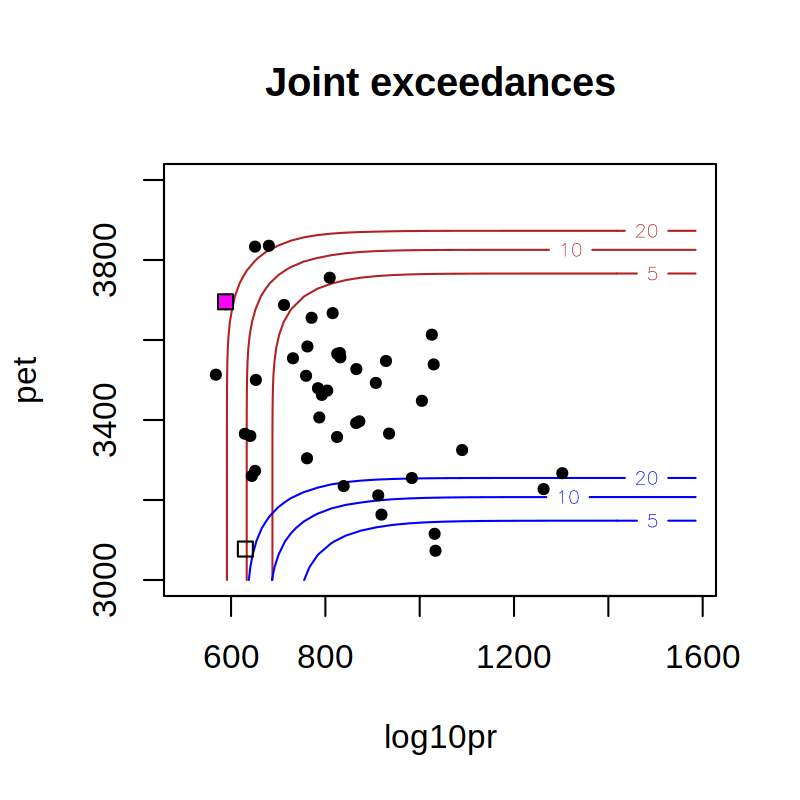

In [123]:
prep_window(c(1,1))

contour(copula_mesh(mdl_pr, mdl_pet, cfit, gmst_2022), levels = 1/c(5,10,20), labels = c(5,10,20), col = "firebrick",
        main = "Joint exceedances", xlab = mdl_pr$varnm, ylab = mdl_pet$varnm)
contour(copula_mesh(mdl_pr, mdl_pet, cfit, gmst_cf), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)

points(10^mdl_pr$x, mdl_pet$x, pch = 20)
points(10^mdl_pr$x[mdl_pr$ev_idx], mdl_pet$x[mdl_pet$ev_idx], pch = 20, col = "magenta", cex = 1.5)

points(rl_pr$"2022", rl_pet$"2022", pch = 0)
points(rl_pr$"hist", rl_pet$"hist", pch = 0)

#### **Marginal changes**

In [ ]:
# load data
pr_df <- merge(merge(merge(load_ts("ts/EA-drought_gmst-smoothed.dat", col.names = c("year", "gmst")),
                     load_ts(paste0("ts/EA-drought_pr-24_cpc.dat"), col.names = c("year", "pr"))),
               load_ts(paste0("ts/EA-drought_pet-24_cpc.dat"), col.names = c("year", "pet"))),
               load_ts(paste0("ts/EA-drought_spei-24_cpc.dat"), col.names = c("year", "spei")))
pr_df["log10_pr"] <- log10(pr_df$pr)

gmst_2022 <- pr_df$gmst[pr_df$year == 2022]
gmst_cf <- gmst_2022 - 1.2

In [ ]:
# fit base models
mdl_pr <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
mdl_pet <- fit_ns("norm", "shift", pr_df, varnm = "pet", covnm_1 = "gmst", lower = F)
mdl_spei <- fit_ns("norm", "shift", pr_df, varnm = "spei", covnm_1 = "gmst", lower = T)

rp_pr <- 1/map_to_u(mdl_pr)[mdl_pr$ev_idx]
rp_pet <- 1/map_to_u(mdl_pet)[mdl_pet$ev_idx]
rp_spei <- 1/map_to_u(mdl_spei)[mdl_spei$ev_idx]

change_in_intensity <- c("pr" = Delta_I(mdl_pr, rp = rp_pr, cov1 = gmst_2022, cov1_cf = gmst_cf, relative = F),
                         "pet" = Delta_I(mdl_pet, rp = rp_pet, cov1 = gmst_2022, cov1_cf = gmst_cf, relative = F),
                         "spei" = Delta_I(mdl_spei, rp = rp_spei, cov1 = gmst_2022, cov1_cf = gmst_cf, relative = F))

In [ ]:
# bootstrap sample for change in intensity
nsamp <- 1000
set.seed(1)
boot_res <- sapply(1:nsamp, function(i) {
    
    # resample data, refit models
    boot_df <- pr_df[sample(1:nrow(pr_df), nrow(pr_df), replace = T),]
    bootmdl_pr <- fit_ns(mdl_pr$dist, mdl_pr$type, boot_df, varnm = mdl_pr$varnm, covnm_1 = mdl_pr$covnm_1, covnm_2 = mdl_pr$covnm_2, lower = mdl_pr$lower)
    bootmdl_pet <- fit_ns(mdl_pet$dist, mdl_pet$type, boot_df, varnm = mdl_pet$varnm, covnm_1 = mdl_pet$covnm_1, covnm_2 = mdl_pet$covnm_2, lower = mdl_pet$lower)
    bootmdl_spei <- fit_ns(mdl_spei$dist, mdl_spei$type, boot_df, varnm = mdl_spei$varnm, covnm_1 = mdl_spei$covnm_1, covnm_2 = mdl_spei$covnm_2, lower = mdl_spei$lower)
    
    c("pr" = Delta_I(bootmdl_pr, rp = rp_pr, cov1 = gmst_2022, cov1_cf = gmst_cf, relative = F),
      "pet" = Delta_I(bootmdl_pet, rp = rp_pet, cov1 = gmst_2022, cov1_cf = gmst_cf, relative = F),
      "spei" = Delta_I(bootmdl_spei, rp = rp_spei, cov1 = gmst_2022, cov1_cf = gmst_cf, relative = F))
})

In [ ]:
boxplot(t(boot_res))

In [ ]:
par(mfrow = c(1,3))
boxplot(t(boot_res[c("pr", "pet"),]))
boxplot(boot_res["pet",])

---
## **Models**

In [8]:
source("../wwa_nonstationary_fitting.r")

model_results <- function(df, dist, fittype, varnm, covnm_1, covnm_2 = NA, cov1_2022, cov1_hist, cov1_fut, cov2_2022 = 0, cov2_hist = 0, cov2_fut = 0,
                                lower = F, rp = 10, delta_relative = T, nsamp = 1000, seed = 1) {
    
    # FUNCTION TO CARRY OUT ALL ATTRIBUTION RUNS & PRODUCE RESULTS IN SPREADSHEET-FRIENDLY FORM
    
    set.seed(seed)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # FIT MODEL to three different subsets: for evaluation, attribution & projection
    
    df_eval <- df[df$year >= 1979 & df$year <= 2022,]
    df_attr <- df[df$year <= 2022,]
    df_proj <- df[df$year <= 2050,]
    
    mdl_eval <- fit_ns(dist, fittype, df_eval, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    mdl_attr <- fit_ns(dist, fittype, df_attr, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    mdl_proj <- fit_ns(dist, fittype, df_proj, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## EVALUATION (get model parameters)
    
    if(fittype == "fixeddisp") {
        disp_eval <- mdl_eval$par["sigma0"] / mdl_eval$par["mu0"]
        boot_eval <- sapply(1:nsamp, function(i) {
            
            boot_df <- df_eval[sample(1:nrow(df_eval), nrow(df_eval), replace = T),]
            boot_mdl <- fit_ns(mdl_eval$dist, mdl_eval$type, boot_df, varnm = mdl_eval$varnm, covnm_1 = mdl_eval$covnm_1, covnm_2 = mdl_eval$covnm_2, lower = mdl_eval$lower)
            boot_mdl$par["sigma0"] / boot_mdl$par["mu0"]
        })
        ci_eval <- setNames(c(disp_eval, quantile(boot_eval, c(0.025, 0.975))),
                            c("disp_est", "disp_lower", "disp_upper"))
    } else {
        var_eval <- mdl_eval$par["sigma0"]
        boot_eval <- sapply(1:nsamp, function(i) {
            
            boot_df <- df_eval[sample(1:nrow(df_eval), nrow(df_eval), replace = T),]
            boot_mdl <- fit_ns(mdl_eval$dist, mdl_eval$type, boot_df, varnm = mdl_eval$varnm, covnm_1 = mdl_eval$covnm_1, covnm_2 = mdl_eval$covnm_2, lower = mdl_eval$lower)
            boot_mdl$par["sigma0"]
        })
        ci_eval <- setNames(c(var_eval, quantile(boot_eval, c(0.025, 0.975))),
                            c("var_est", "var_lower", "var_upper"))
    }
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## ATTRIBUTION (get event value, PR & DI)
    
    rl_2022 <- map_from_u(1/rp, mdl_attr, cov1 = cov1_2022, cov2 = cov2_2022)
    if(substr(varnm,1,5) == "log10") { actual_rl2022 <- 10^rl_2022 } else { actual_rl2022 <- rl_2022 }
    
    pr_eval <- prob_ratio(mdl_attr, rl_2022, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist)
    dI_eval <- Delta_I(mdl_attr, rp, cov1 = cov1_2022, cov1_cf = cov1_hist, relative = delta_relative)
    
    boot_attr <- sapply(1:nsamp, function(i) {
        
        boot_df <- df_attr[sample(1:nrow(df_attr), nrow(df_attr), replace = T),]
        boot_mdl <- fit_ns(mdl_attr$dist, mdl_attr$type, boot_df, varnm = mdl_attr$varnm, covnm_1 = mdl_attr$covnm_1, covnm_2 = mdl_attr$covnm_2, lower = mdl_attr$lower)
        
        boot_pr <- prob_ratio(boot_mdl, rl_2022, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist)
        boot_di <- Delta_I(boot_mdl, 10, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist, relative = delta_relative)
        
        c("PR" = boot_pr, "DI" = boot_di)
    })
    ci_attr <- rbind("est" = c(pr_eval, dI_eval), apply(boot_attr, 1, quantile, c(0.025, 0.975)))
    ci_attr <- unlist(lapply(colnames(ci_attr), function(cnm) setNames(ci_attr[,cnm], paste("attr", cnm, c("est", "lower", "upper"), sep = "_"))))
                          
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## PROJECTION (get PR & DI)

    pr_proj <- prob_ratio(mdl_proj, rl_2022, cov1 = cov1_2022, cov1_cf = cov1_fut, cov2 = cov2_2022, cov2_cf = cov2_fut)
    dI_proj <- Delta_I(mdl_proj, 10, cov1 = cov1_2022, cov1_cf = cov1_fut, relative = delta_relative)
                             
    boot_proj <- sapply(1:nsamp, function(i) {
        
        boot_df <- df_proj[sample(1:nrow(df_proj), nrow(df_proj), replace = T),]
        boot_mdl <- fit_ns(mdl_proj$dist, mdl_proj$type, boot_df, varnm = mdl_proj$varnm, covnm_1 = mdl_proj$covnm_1, covnm_2 = mdl_proj$covnm_2, lower = mdl_proj$lower)
        
        boot_pr <- prob_ratio(boot_mdl, rl_2022, cov1 = cov1_2022, cov1_cf = cov1_fut, cov2 = cov2_2022, cov2_cf = cov2_fut)
        boot_di <- Delta_I(boot_mdl, 10, cov1 = cov1_2022, cov1_cf = cov1_fut, cov2 = cov2_2022, cov2_cf = cov2_fut, relative = delta_relative)
        
        c("PR" = boot_pr, "DI" = boot_di)
    })
    ci_proj <- rbind("est" = c(pr_proj, dI_proj), apply(boot_proj, 1, quantile, c(0.025, 0.975)))
      
    # invert
    ci_proj[,"PR"] <- 1/ci_proj[c(1,3,2),"PR"]
    ci_proj[,"DI"] <- -ci_proj[c(1,3,2),"DI"]   
                             
    ci_proj <- unlist(lapply(colnames(ci_proj), function(cnm) setNames(ci_proj[,cnm], paste("proj", cnm, c("est", "lower", "upper"), sep = "_"))))
                             
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                             
    # t(setNames(data.frame(c(ci_eval, "rp_value" = actual_rl2022, ci_attr, ci_proj)), gsub(".dat", "", gsub(".+pr-mam_", "", fnm))))      
    t(data.frame(c(ci_eval, "rp_value" = actual_rl2022, ci_attr, ci_proj)))     
}



### **CORDEX**

#### **Precipitation indices**

In [9]:
# fit model & get results for each season
invisible(sapply(c("mam", "ond", "24"), function(seas) {
    
    rp <- return_periods[[seas]]                  # return period depending on variable
    if(seas == "ond") { covnm_2 = "nino_ond" } else { covnm_2 = NA }      # OND needs second covariate
    
    # loop over all available models, get results for each
    res <- sapply(list.files("ts", pattern = paste0("pr-",seas,"_AFR"), full.names = T), function(fnm) {
        
        if(grepl("HadGEM2-ES_r1_RegCM4-3", fnm)) {return(rep(NA, 16))}
        
        # load necessary data
        gmst_fnm <- list.files("ts", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],".dat"), full.names = T)
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        
        nino_fnm <- list.files("ts", paste0("nino-ond_",strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],".dat"), full.names = T)
        nino <- load_ts(nino_fnm, col.names = c("year", "nino_ond"))
        
        pr <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), pr)
        df["log10pr"] <- log10(df$pr)   # fit models to log precip, convert back at the end (more stable model fitting)
        
        # covariates defining current, past & future climates
        gmst_2022 <- gmst[gmst$year == 2022, "gmst"]
        gmst_hist <- gmst_2022 - 1.2
        gmst_fut <- gmst_2022 + 0.8
        nino_2022 <- nino_hist <- nino_fut <- 0    # dummy covariates
        
        # fit model & get results
        data.frame(model_results(df, "norm", "fixeddisp", varnm = "log10pr", covnm_1 = "gmst", covnm_2 = covnm_2, lower = T, rp = rp, delta_relative = T, nsamp = 1000,
                                       cov1_2022 = gmst_2022, cov1_hist = gmst_hist, cov1_fut = gmst_fut, 
                                       cov2_2022 = nino_2022, cov2_hist = nino_hist, cov2_fut = nino_fut))
    }, simplify = F)
    
    # merge results into single dataframe, tidy rownames & save to csv
    res <- do.call("rbind", res)
    rownames(res) <- gsub(".dat", "", gsub(paste0(".+pr-",seas,"_"), "", rownames(res)))
    write.csv(res, paste0("res/EA-drought_pr-",seas,"_cordex_fitted.csv"))
}))

#### **PET & SPEI**

In [19]:
# fit model & get results for each season
invisible(sapply(c("pet", "spei"), function(varnm) {
    
    rp <- return_periods[[varnm]]                  # return period depending on variable
    lower <- list("pet" = F, "spei" = T)[[varnm]]                # consider lower or upper tail, depending on variable
    relative_delta <- list("pet" = T, "spei" = F)[[varnm]]
    
    # loop over all available models, get results for each
    res <- sapply(sort(list.files("ts", pattern = paste0("_",varnm,"-24_AFR"), full.names = T)), function(fnm) {
        
        if(grepl("HadGEM2-ES_r1_RegCM4-3", fnm)) {return(rep(NA, 16))}
        
        # load necessary data
        gmst_fnm <- list.files("ts", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],".dat"), full.names = T)
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        
        pr <- load_ts(fnm, col.names = c("year", varnm))
        df <- merge(gmst, pr)
        df <- df[!is.na(df[,varnm]),]
        
        # covariates defining current, past & future climates
        gmst_2022 <- gmst[gmst$year == 2022, "gmst"]
        gmst_hist <- gmst_2022 - 1.2
        gmst_fut <- gmst_2022 + 0.8
        nino_2022 <- nino_hist <- nino_fut <- 0    # dummy covariates
        
        # fit model & get results
        data.frame(model_results(df, "norm", "shift", varnm = varnm, covnm_1 = "gmst", covnm_2 = NA, lower = lower, rp = rp, delta_relative = relative_delta, nsamp = 1000,
                                       cov1_2022 = gmst_2022, cov1_hist = gmst_hist, cov1_fut = gmst_fut, 
                                       cov2_2022 = nino_2022, cov2_hist = nino_hist, cov2_fut = nino_fut))
    }, simplify = F)
    
    # merge results into single dataframe, tidy rownames & save to csv
    res <- do.call("rbind", res)
    rownames(res) <- gsub(".dat", "", gsub(".+-24_", "", rownames(res)))
    write.csv(res, paste0("res/EA-drought_",varnm,"-24_cordex_fitted.csv"))
}))

#### **Joint distribution**
_Plotting will be done in Python - however, R is better for model fitting & computing contour surfaces - hence saving them in a portable format_

In [99]:
library(jsonlite) # need to save as json in order to load in python

# need to fix limits of copula mesh : use 50-year return level + 2sd?

# loop over files, get joint structure & contour surfaces
invisible(sapply(sort(list.files("ts", pattern = "_pet-24_AFR", full.names = T)), function(fnm) {
    
    mdl <- gsub(".+pet-24_", "", gsub(".dat", "", fnm))
    
    # load data
    gmst_fnm <- list.files("ts", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4],"_rcp85_",strsplit(fnm, "_")[[1]][5],".dat"), full.names = T)
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    
    pet <- load_ts(fnm, col.names = c("year", "pet"))
    pr <- load_ts(gsub("pet", "pr", fnm), col.names = c("year", "pr"))
    
    df <- merge(merge(gmst, pet), pr)
    df$log10pr <- log10(df$pr)
    
    # fix covariate values
    gmst_2022 <- df$gmst[df$year == "2022"]
    gmst_hist <- gmst_2022 - 1.2
    gmst_fut <- gmst_2022 + 0.8
    
    # fit marginal distributions
    mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "log10pr", covnm_1 = "gmst", lower = T)
    mdl_pet <- fit_ns("norm", "shift", df, varnm = "pet", covnm_1 = "gmst", lower = F)
    
    # get return levels in factual & counterfactual climates
    rl_pr <- lapply(list("2022" = gmst_2022, "hist" = gmst_hist, "fut" = gmst_fut), function(cov) {
        map_from_u(1/return_periods[["24"]], mdl_pr, cov1 = cov)
    })
    rl_pet <- lapply(list("2022" = gmst_2022, "hist" = gmst_hist, "fut" = gmst_fut), function(cov) {
        map_from_u(1/return_periods[["pet"]], mdl_pet, cov1 = cov)
    })
    
    # transform marginals to U
    u_pr <- map_to_u(mdl_pr)
    u_tas <- map_to_u(mdl_pet)
    
    # fit copula to u,v pairs
    fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_tas), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
    cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula
    
    # get contour surfaces
    contours <- list("coef" = coef(fitted_copula),
                     "rl_pr" = rl_pr,
                     "rp_pet" = rl_pet,
                     "current" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_2022, 
                     "hist" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_hist),
                     "fut" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_fut))
    
    # save surfaces for plotting in python
    write_json(contours, paste0("mv/joint-fit_pr-24_pet-24_",mdl,".json"))
}))

### **HighResMIP**

In [11]:
source("../wwa_nonstationary_fitting.r")

# load covariate data
cov_df <- merge(load_ts("ts/EA-drought_gmst-smoothed.dat", col.names = c("year", "gmst")),
                load_ts("ts/EA-drought_detrended-nino-ond.dat", col.names = c("year", "nino_ond")))

# fix covariate values defining current, past & future climates
gmst_2022 <- cov_df[cov_df$year == 2022, "gmst"]
gmst_hist <- gmst_2022 - 1.2
gmst_fut <- gmst_2022 + 0.8

nino_2022 <- nino_hist <- nino_fut <- cov_df[cov_df$year == 2022, "nino_ond"]

In [20]:
hiresmip_results <- function(df, dist, fittype, varnm, covnm_1, covnm_2 = NA, cov1_2022, cov1_hist, cov1_fut = NA, cov2_2022 = 0, cov2_hist = 0, cov2_fut = NA,
                                lower = F, rp = 10, delta_relative = T, nsamp = 1000, seed = 1) {
    
    # FUNCTION TO CARRY OUT ALL ATTRIBUTION RUNS & PRODUCE RESULTS IN SPREADSHEET-FRIENDLY FORM
    
    set.seed(seed)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # FIT MODEL to three different subsets: for evaluation, attribution & projection
    
    df_eval <- df[df$year >= 1979 & df$year <= 2022,]
    df_attr <- df[df$year <= 2022,]
    
    mdl_eval <- fit_ns(dist, fittype, df_eval, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    mdl_attr <- fit_ns(dist, fittype, df_attr, varnm = varnm, covnm_1 = covnm_1, covnm_2 = covnm_2, lower = lower)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## EVALUATION (get model parameters)
    
    disp_eval <- mdl_eval$par["sigma0"] / mdl_eval$par["mu0"]
    var_eval <- mdl_eval$par["sigma0"]
    boot_eval <- sapply(1:nsamp, function(i) {
        
        boot_df <- df_eval[sample(1:nrow(df_eval), nrow(df_eval), replace = T),]
        boot_mdl <- fit_ns(mdl_eval$dist, mdl_eval$type, boot_df, varnm = mdl_eval$varnm, covnm_1 = mdl_eval$covnm_1, covnm_2 = mdl_eval$covnm_2, lower = mdl_eval$lower)
        if(fittype == "fixeddisp") {
            boot_mdl$par["sigma0"] / boot_mdl$par["mu0"]
        } else {
            boot_mdl$par["sigma0"]
        }
    })
    if(fittype == "fixeddisp") {
        ci_eval <- setNames(c(disp_eval, quantile(boot_eval, c(0.025, 0.975))),
                            c("disp_est", "disp_lower", "disp_upper"))
    } else {
        ci_eval <- setNames(c(var_eval, quantile(boot_eval, c(0.025, 0.975))),
                            c("var_est", "var_lower", "var_upper"))
    }
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## ATTRIBUTION (get event value, PR & DI)
    
    rl_2022 <- map_from_u(1/rp, mdl_attr, cov1 = cov1_2022, cov2 = cov2_2022)
    if(substr(varnm,1,5) == "log10") { actual_rl2022 <- 10^rl_2022 } else { actual_rl2022 <- rl_2022 }
    
    pr_eval <- prob_ratio(mdl_attr, rl_2022, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist)
    dI_eval <- Delta_I(mdl_attr, rp, cov1 = cov1_2022, cov1_cf = cov1_hist, relative = delta_relative)
    
    boot_attr <- sapply(1:nsamp, function(i) {
        
        boot_df <- df_attr[sample(1:nrow(df_attr), nrow(df_attr), replace = T),]
        boot_mdl <- fit_ns(mdl_attr$dist, mdl_attr$type, boot_df, varnm = mdl_attr$varnm, covnm_1 = mdl_attr$covnm_1, covnm_2 = mdl_attr$covnm_2, lower = mdl_attr$lower)
        
        boot_pr <- prob_ratio(boot_mdl, rl_2022, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist)
        boot_di <- Delta_I(boot_mdl, rp, cov1 = cov1_2022, cov1_cf = cov1_hist, cov2 = cov2_2022, cov2_cf = cov2_hist, relative = delta_relative)
        
        c("PR" = boot_pr, "DI" = boot_di)
    })
    ci_attr <- rbind("est" = c(pr_eval, dI_eval), apply(boot_attr, 1, quantile, c(0.025, 0.975)))
    ci_attr <- unlist(lapply(colnames(ci_attr), function(cnm) setNames(ci_attr[,cnm], paste("attr", cnm, c("est", "lower", "upper"), sep = "_"))))
                             
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Can't do future projection, because using observed GMST & Nino time series as covariates
                             
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                             
    # t(setNames(data.frame(c(ci_eval, "rp_value" = rl_2022, ci_attr, ci_proj)), gsub(".dat", "", gsub(".+pr-mam_", "", fnm))))      
    t(data.frame(c(ci_eval, "rp_value" = actual_rl2022, ci_attr)))     
}

#### **Precipitation indices**

In [13]:
# fit model & get results for each season
invisible(sapply(c("mam", "ond", "24"), function(seas) {
    
    rp <- return_periods[[seas]]                  # return period depending on variable
    if(seas == "ond") { covnm_2 = "nino_ond" } else { covnm_2 = NA }      # OND needs second covariate
    
    # loop over all available models, get results for each
    res <- sapply(list.files("ts", pattern = paste0("pr-",seas,"_highres"), full.names = T), function(fnm) {
        
        pr <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(cov_df, pr)
        df["log10pr"] <- log10(df$pr)   # fit models to log precip, convert back at the end (more stable model fitting)
        
        data.frame(hiresmip_results(df, "norm", "fixeddisp", varnm = "log10pr", covnm_1 = "gmst", covnm_2 = covnm_2, lower = T, rp = rp, delta_relative = T, nsamp = 1000,
                                       cov1_2022 = gmst_2022, cov1_hist = gmst_hist, cov1_fut = gmst_fut, 
                                       cov2_2022 = nino_2022, cov2_hist = nino_hist, cov2_fut = nino_fut))
    }, simplify = F)
    
    # merge results into single dataframe, tidy rownames & save to csv
    res <- do.call("rbind", res)
    rownames(res) <- gsub(".dat", "", gsub(".+highresSST_", "", rownames(res)))
    write.csv(res, paste0("res/EA-drought_pr-",seas,"_highresmip_fitted.csv"))
}))

#### **PET & SPEI**

In [126]:
invisible(sapply(c("pet", "spei"), function(varnm) {
    
    rp <- return_periods[[varnm]]                  # return period depending on variable
    lower <- list("pet" = F, "spei" = T)[[varnm]]                # consider lower or upper tail, depending on variable
    relative_delta <- list("pet" = T, "spei" = F)[[varnm]]
    
    # loop over all available models, get results for each
    res <- sapply(list.files("ts", pattern = paste0(varnm, "-24_highres"), full.names = T), function(fnm) {
        
        ts <- load_ts(fnm, col.names = c("year", varnm))
        ts <- ts[!is.na(ts[,varnm]),]   # only fit to finite SPEI values (avoids problem of truncation of high values)
        df <- merge(cov_df, ts)
        
        data.frame(hiresmip_results(df, "norm", "shift", varnm = varnm, covnm_1 = "gmst", lower = lower, rp = rp, delta_relative = relative_delta, nsamp = 1000,
                                       cov1_2022 = gmst_2022, cov1_hist = gmst_hist, cov1_fut = gmst_2022, 
                                       cov2_2022 = nino_2022, cov2_hist = nino_hist, cov2_fut = gmst_2022))
        }, simplify = F)
    
    # merge results into single dataframe, tidy rownames & save to csv
    res <- do.call("rbind", res)
    rownames(res) <- gsub(".dat", "", gsub(".+highresSST_", "", rownames(res)))
    write.csv(res, paste0("res/EA-drought_",varnm,"-24_highresmip_fitted.csv"))
}))

#### **Joint distribution**
_Plotting will be done in Python - however, R is better for model fitting & computing contour surfaces - hence saving them in a portable format_

In [80]:
library(jsonlite) # need to save as json in order to load in python

# observed GMST used as covariate for HighResMIP models
gmst <- load_ts("ts/EA-drought_gmst-smoothed.dat", col.names = c("year", "gmst"))

# fix covariate values
gmst_2022 <- df$gmst[df$year == "2022"]
gmst_hist <- gmst_2022 - 1.2
gmst_fut <- gmst_2022 + 0.8


# loop over files, get joint structure & contour surfaces
invisible(sapply(sort(list.files("ts", pattern = "_pet-24_highresSST", full.names = T)), function(fnm) {
    
    mdl <- gsub(".+pet-24_", "", gsub(".dat", "", fnm))

    # load data
    pet <- load_ts(fnm, col.names = c("year", "pet"))
    pr <- load_ts(gsub("pet", "pr", fnm), col.names = c("year", "pr"))
    
    df <- merge(merge(gmst, pet), pr)
    df$log10pr <- log10(df$pr)
    
    # fit marginal distributions
    mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "log10pr", covnm_1 = "gmst", lower = T)
    mdl_pet <- fit_ns("norm", "shift", df, varnm = "pet", covnm_1 = "gmst", lower = F)
    
    # get return levels in factual & counterfactual climates
    rl_pr <- lapply(list("2022" = gmst_2022, "hist" = gmst_hist, "fut" = gmst_fut), function(cov) {
        map_from_u(1/return_periods[["24"]], mdl_pr, cov1 = cov)
    })
    rl_pet <- lapply(list("2022" = gmst_2022, "hist" = gmst_hist, "fut" = gmst_fut), function(cov) {
        map_from_u(1/return_periods[["pet"]], mdl_pet, cov1 = cov)
    })
    
    # transform marginals to U
    u_pr <- map_to_u(mdl_pr)
    u_tas <- map_to_u(mdl_pet)
    
    # fit copula to u,v pairs
    fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_tas), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
    cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula
    
    # get contour surfaces
    contours <- list("coef" = coef(fitted_copula),
                     "rl_pr" = rl_pr,
                     "rp_pet" = rl_pet,
                     "current" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_2022), 
                     "hist" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_hist),
                     "fut" = copula_mesh(mdl_pr, mdl_pet, cfit, gmst_fut))
    
    # save surfaces for plotting in python
    write_json(contours, paste0("mv/joint-fit_pr-24_pet-24_",mdl,".json"))
}))

---
## **Station data**

In [ ]:
source("../wwa_nonstationary_fitting.r")

# load covariate data
df <- merge(load_ts("ts/EA-drought_gmst-smoothed.dat", col.names = c("year", "gmst")),
            load_ts("ts/EA-drought_detrended-nino-ond.dat", col.names = c("year", "nino_ond")))

# fix covariate values
gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

ondnino_2022 <- ondnino_cf <- df[df$year == 2022, "nino_ond"]

### **Trend plots**

In [ ]:
# Trends in GMST
prep_window(c(2,4))
par(mar = c(3.5,3.5,3.5,3.5))
invisible(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, load_ts(fnm, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    
    plot_gmsttrend(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, ylab = "log10 precip", legend_pos = NA, main = stn)
    yticks <- c(50,seq(100,1500,100), seq(2000,5000,500))
    axis(4, at = log10(yticks), labels = yticks)
    mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
}))
plot.new()
legend("left", legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", rep("blue", 2)), lwd = c(2,2,1))

In [ ]:
# Return level plots
prep_window(c(2,4))
par(mar = c(3.5,3.5,3.5,3.5))
invisible(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, load_ts(fnm, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    
    plot_returnperiods(mdl, cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, ylab = "log10 precip", main = stn)
    
    yticks <- c(50,seq(100,1500,100), seq(2000,5000,500))
    axis(4, at = log10(yticks), labels = yticks)
    mtext("Precip (mm)", side = 4, line = 2.5, cex = par("cex"))
    
}))

In [ ]:
# Trends over time

prep_window(c(2,4))
par(mar = c(3.5,3.5,3.5,3.5))
invisible(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, load_ts(fnm, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    mdl <- fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T)
    rp_2022 <- 1/map_to_u(mdl)[mdl$ev_idx]
    
    plot(pr_df[,c("year", "precip")], type = "S", lwd = 2, xlab = "", ylab = "", col = adjustcolor("black", alpha = 0.5), main = paste0(stn, " (rp", round(rp_2022,0),")"))
    lines(pr_df$year, 10^ns_pars(mdl)$loc, type = "S", lwd = 2, col = "black")
    lines(pr_df$year, 10^map_from_u(1/6, mdl, cov1 = mdl$cov1), col = "blue", lwd = 2, type = "s")
    lines(pr_df$year, 10^map_from_u(1/40, mdl, cov1 = mdl$cov1), col = "blue", lwd = 1, type = "s")
    
    points(2022, pr_df$precip[pr_df$year == 2022], col = "magenta", pch = 20, cex = 2)
    mtext("Precip (mm)", side = 2, line = 2.5, cex = par("cex"))
}))
plot.new()
legend("left", legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", rep("blue", 2)), lwd = c(2,2,1))

### **Tables of fitted trends**

In [ ]:
stn_ond_res <- t(sapply(list.files("ts", pattern = "ond_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, load_ts(fnm, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), nsamp = 1000,
                          cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}))
write.csv(stn_ond_res, "res/EA-drought_pr-ond_stations_fitted.csv")

In [ ]:
stn_mam_res <- t(sapply(list.files("ts", pattern = "mam_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, load_ts(fnm, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                          cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}))
write.csv(stn_mam_res, "res/EA-drought_pr-mam_stations_fitted.csv")

In [ ]:
stn_24_res <- t(sapply(list.files("ts", pattern = "24-month_stn", full.names = T), function(fnm) {
    
    stn <- gsub(".dat", "", strsplit(fnm, "-")[[1]][5])
    pr_df <- merge(df, load_ts(fnm, col.names = c("year", "precip")))
    pr_df["log10_pr"] <- log10(pr_df$pr)
    
    bootstrap_obs_results(fit_ns("norm", "fixeddisp", pr_df, varnm = "log10_pr", covnm_1 = "gmst", lower = T), nsamp = 1000,
                          cov1 = gmst_2022, cov1_cf = gmst_cf, cov2 = ondnino_2022, cov2_cf = ondnino_cf, convert_logs = T)
}))
write.csv(stn_mam_res, "res/EA-drought_pr-24_stations_fitted.csv")